Freq_domain_meas
=================

* **[Cavity search](#Cavity-search)** 
Search the location of the cavity with $sweeping$ $LO$ $frequency$ due to large frequency range (e.g. $5.0$ - $7.0$ GHz)

(Frequency range needs to be a `float` number

* **[Accurate Cavity search](#Accurate-Cavity-search)**
Search the location of the cavity with $sweeping$ $NCO$ $frequency$ due to small frequency range (e.g. $6.0$ - $6.04$ GHz)


* **[Power dependent cavity](#Power-dependent-cavity)** 
Search the location of the dress state cavity with $sweeping$ $NCO$ $frequency$ due to small frequency range (e.g. $6.0$ - $6.004$ GHz)

* **[Flux dependent cavity](#Flux-dependent-cavity)** 

* **[Two-tone](#Two-tone)** 


To run this, you will need:
* [QRM-RF](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/qcm_rf.html)
* Device under test: a Superconducting Qubit
* Two SMA-cables
* Installation and enabling of ipywidgets


Cluster Setup
-----

In [1]:
import warnings
from pathlib import Path

import ipywidgets as widgets
import numpy as np
import quantify_core.data.handling as dh
from IPython.display import display
from qblox_instruments import Cluster, ClusterType, PlugAndPlay
from qcodes import Instrument
from qcodes.parameters import ManualParameter
from quantify_core.analysis.single_qubit_timedomain import (
    RabiAnalysis,
    RamseyAnalysis,
    T1Analysis,
)
from quantify_core.measurement.control import MeasurementControl
from quantify_core.visualization.pyqt_plotmon import PlotMonitor_pyqt as PlotMonitor
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement
from quantify_scheduler.gettables import ScheduleGettable
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent
from quantify_scheduler.operations.gate_library import Measure, Reset
from quantify_scheduler.operations.pulse_library import SetClockFrequency, SquarePulse
from quantify_scheduler.resources import ClockResource
from quantify_scheduler.schedules import heterodyne_spec_sched_nco, two_tone_spec_sched_nco, rabi_sched, t1_sched
from quantify_scheduler.schedules.timedomain_schedules import ramsey_sched
from quantify_scheduler.schedules.schedule import Schedule
from quantify_core.analysis.spectroscopy_analysis import QubitSpectroscopyAnalysis

from utils.tutorial_analysis_classes import (
    QubitFluxSpectroscopyAnalysis,
    ResonatorFluxSpectroscopyAnalysis,
)
from utils.tutorial_utils import (
    set_drive_attenuation,
    set_readout_attenuation,
    show_args,
    show_drive_args,
    show_readout_args,
)

# Configure_measurement_control_loop
def configure_measurement_control_loop(
    device: QuantumDevice, cluster: Cluster, live_plotting: bool = False
) -> None:
    # Close QCoDeS instruments with conflicting names
    for name in [
        "PlotMonitor",
        "meas_ctrl",
        "ic",
        "ic_generic",
        f"ic_{cluster.name}",
    ] + [f"ic_{module.name}" for module in cluster.modules]:
        try:
            Instrument.find_instrument(name).close()
        except KeyError as kerr:
            pass

    meas_ctrl = MeasurementControl("meas_ctrl")
    ic = InstrumentCoordinator("ic")

    # Add cluster to instrument coordinator
    ic_cluster = ClusterComponent(cluster)
    ic.add_component(ic_cluster)

    if live_plotting:
        # Associate plot monitor with measurement controller
        plotmon = PlotMonitor("PlotMonitor")
        meas_ctrl.instr_plotmon(plotmon.name)

    # Associate measurement controller and instrument coordinator with the quantum device
    device.instr_measurement_control(meas_ctrl.name)
    device.instr_instrument_coordinator(ic.name)

    return (meas_ctrl, ic)

# Connect to Cluster
warnings.simplefilter("ignore")

with PlugAndPlay() as p:            # Scan for available devices and display
    device_list = p.list_devices()  # Get info of all devices

names = {dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()}
ip_addresses = {dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()}

connect = widgets.Dropdown(         # Create widget for names and ip addresses *** Should be change into other interface in the future
    options=[(f"{names[dev_id]} @{ip_addresses[dev_id]}", dev_id) for dev_id in device_list],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('Marketing-Cluster @192.168.1.170', '00015_2247_002'),), value…

In [2]:
Instrument.close_all()              # Close all existing QCoDeS Instrument instances
dev_id = connect.value
cluster = Cluster(name = "cluster0", identifier = ip_addresses.get(dev_id))
print(f"{connect.label} connected")

# Reset the cluster
cluster.reset()        
print(cluster.get_system_state())

# Quantum device settings
hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster0": {
        "sequence_to_file": False,  # Boolean flag which dumps waveforms and program dict to JSON file
        "ref": "internal",  # Use shared clock reference of the cluster
        "instrument_type": "Cluster",
        # ============ DRIVE ============#
        "cluster0_module4": {
            "instrument_type": "QCM_RF",
            "complex_output_0": {
                "output_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "portclock_configs": [
                    {
                        "port": "qubit:mw",
                        "clock": "qubit.01",
                        "interm_freq": 80e6,
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
        # ============ FLUX ============#
        "cluster0_module2": {
            "instrument_type": "QCM",
            "real_output_0": {"portclock_configs": [{"port": "qubit:fl", "clock": "cl0.baseband"}]},
        },
        # ============ READOUT ============#
        "cluster0_module8": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "output_att": 0,
                "input_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "lo_freq": 5.8e9,       # *** Should be set as a parameter later on
                "portclock_configs": [
                    {
                        "port": "qubit:res",
                        "clock": "qubit.ro",
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
    },
}

qubit = BasicTransmonElement("qubit")
qubit.measure.acq_channel(8)

quantum_device = QuantumDevice("device_1q")
quantum_device.hardware_config(hardware_cfg) 

quantum_device.add_element(qubit)  # We always reset the cluster again, so the information about qubit will be dispose, then add again here.

meas_ctrl, instrument_coordinator = configure_measurement_control_loop(quantum_device, cluster)


Marketing-Cluster @192.168.1.170 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Cavity search
-------------
> Under construction, unable to use

> Need to know if it is able to set LO freq as a variable

Sweeping LO frequency to get the location frequency of all cavities, the frequency you get will be the $bare$ $state$ $frequency$.

In [23]:
# Parameters 
meas_datadir = 'D:\HW\量子元件實驗室\Qblox\Qblox_datadir'
flux_val = 0.0
ro_out_att = 40
meas_repetitions = 800
meas_start_freq = 5.99e9  # Range ~40MHz
meas_stop_freq = 6.03e9
meas_datapoints = 300

# ----------------------------separation line------------------------------------

dh.set_datadir(meas_datadir)

# Configure external flux control
flux_settable: callable = cluster.module2.out0_offset
flux_settable(flux_val)

# Configure NCO freq

# Activate NCO delay compensation
# *** Need to check if this is required also in Cavity search
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

AttributeError: 'QcmQrm' object and its delegates have no attribute 'interm_freq'

Accurate Cavity search
-------------

After fixing the approximate resonator frequencies, 
sweeping NCO frequency to get the location frequency of all cavities, 
the frequency you get will be the accurate $bare$ $state$ $frequency$.

This can also check the $dress$ $state$ $frequency$ by changing **ro_out_att** value.

spec_sched_kwargs
pulse_amp         = 0.1
pulse_duration    = 2e-06
frequencies       = freq
acquisition_delay = 5e-07
integration_time  = 1e-06
port              = qubit:res
clock             = qubit.ro
init_duration     = 1e-05
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 100

100% completed | elapsed time:      7s | time left:      0s  last batch size:    100  
100% completed | elapsed time:      7s | time left:      0s  last batch size:    100  

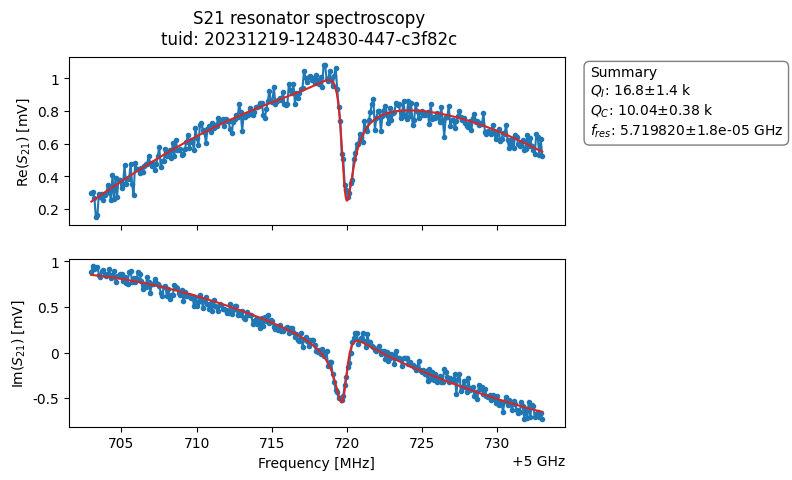

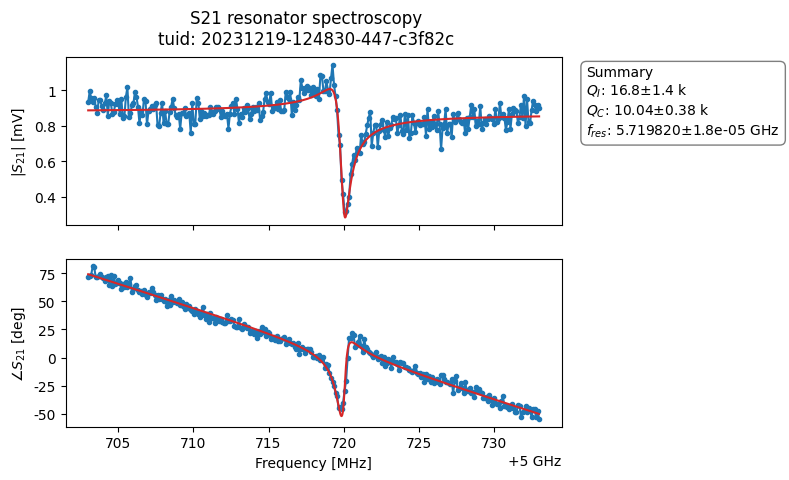

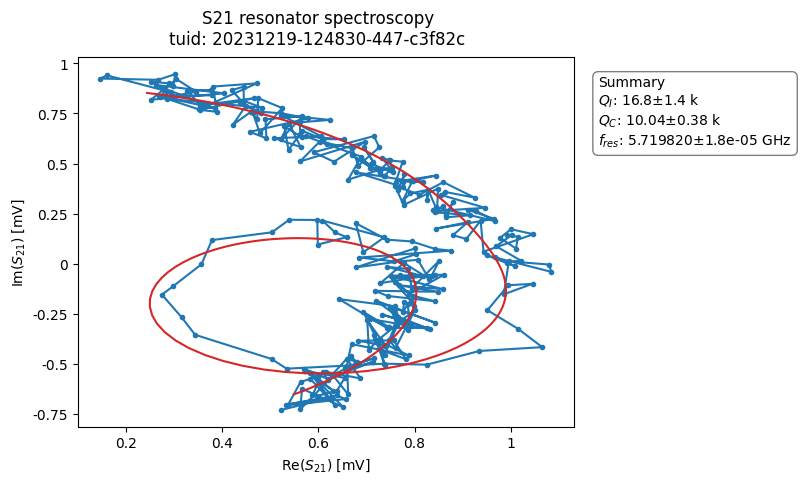

In [3]:
# Parameters 
meas_datadir = 'D:\HW\量子元件實驗室\Qblox\Qblox_datadir'
flux_val = 0.0
ro_out_att = 40
meas_repetitions = 800
meas_center_freq = 5.718e9  # Range ~40MHz
meas_range_freq = 15e6
meas_datapoints = 300

# ----------------------------separation line------------------------------------

dh.set_datadir(meas_datadir)

# Configure external flux control
flux_settable: callable = cluster.module2.out0_offset
flux_settable(flux_val)

# Activate NCO delay compensation
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True
freq.batch_size = 100

spec_sched_kwargs = dict(    # *** Try to draw the prospective wave as a plot for a great check of the outputting pulse. And turn them into parameters
    pulse_amp=0.1,           # *** Check the unit of amplitude, only scale or volt # Can be set as a parameter
    pulse_duration=2e-6,     # *** Can be set as a parameter
    frequencies=freq,
    acquisition_delay=5e-7,# *** Can be set as a parameter
    integration_time=1e-6,   # *** Can be set as a parameter
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
    init_duration=10e-6,     # *** Can be set as a parameter
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,  # *** Def: https://quantify-os.org/docs/quantify-scheduler/dev/autoapi/quantify_scheduler/schedules/index.html
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)
show_args(spec_sched_kwargs, title="spec_sched_kwargs")  # *** Try to insert this into interfaces

set_readout_attenuation(quantum_device, qubit, out_att=ro_out_att, in_att=0)

quantum_device.cfg_sched_repetitions(meas_repetitions)

frequency_setpoints = np.linspace(meas_center_freq - meas_range_freq, meas_center_freq + meas_range_freq, meas_datapoints)  # ***Check if this is just a monitoring number or it's really measuring with this freq
meas_ctrl.settables(freq)
meas_ctrl.setpoints(frequency_setpoints)

rs_ds = meas_ctrl.run("resonator spectroscopy")
rs_ds

from quantify_core.analysis.spectroscopy_analysis import ResonatorSpectroscopyAnalysis

rs_analysis = ResonatorSpectroscopyAnalysis(tuid=rs_ds.attrs["tuid"], dataset=rs_ds)
rs_analysis.run().display_figs_mpl()

Power dependent cavity
------------------------

Sweeping NCO frequency to get the location dress state frequency of each cavity found in cavity search, with 2D plot we can get the $intensity$ $of$ $the$ $signal$ and $dress$ $state$ $frequency$

The Q1ASM sequencer program only supports integer values. However, the NCO has a frequency resolution of 0.25 Hz. As such, the frequency values in the sequencer program must be given as integer multiples of $1/4$ Hz.

spec_sched_kwargs
pulse_amp         = ro_pulse_amp
pulse_duration    = 2e-06
frequencies       = freq
acquisition_delay = 1.96e-07
integration_time  = 2e-06
init_duration     = 1e-05
port              = qubit:res
clock             = qubit.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 ro_pulse_amp 
Batched settable(s):
	 freq 
Batch size limit: 1024

100% completed | elapsed time:     23s | time left:      0s  last batch size:    300  
100% completed | elapsed time:     23s | time left:      0s  last batch size:    300  

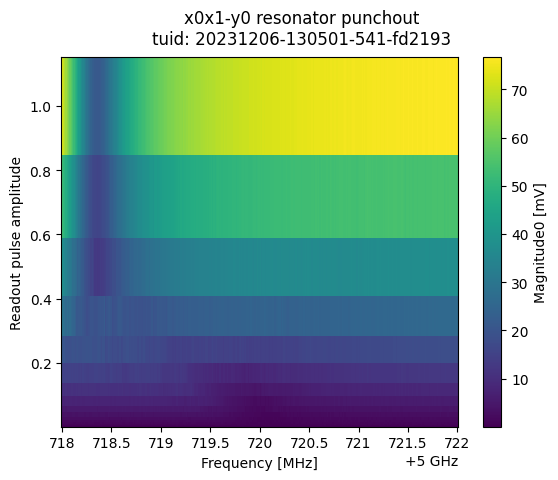

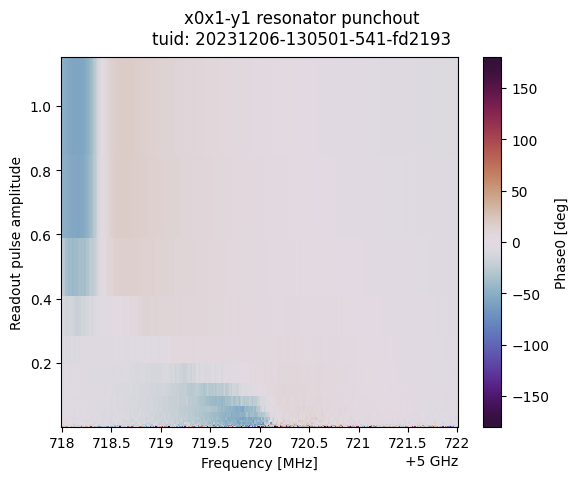

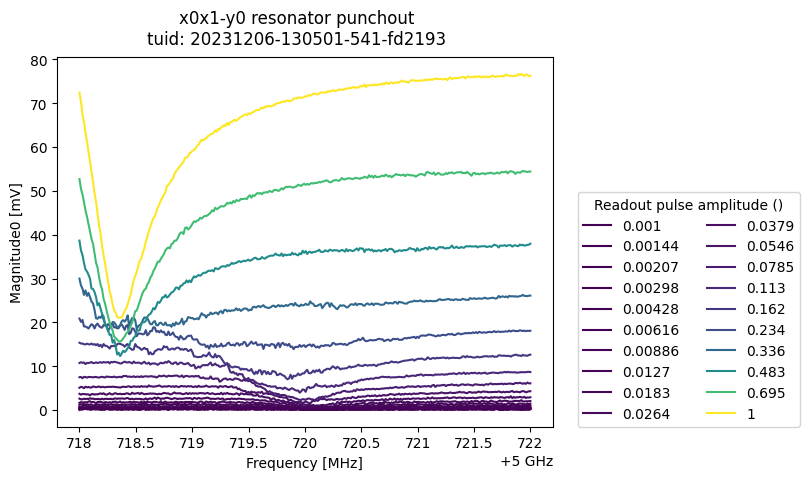

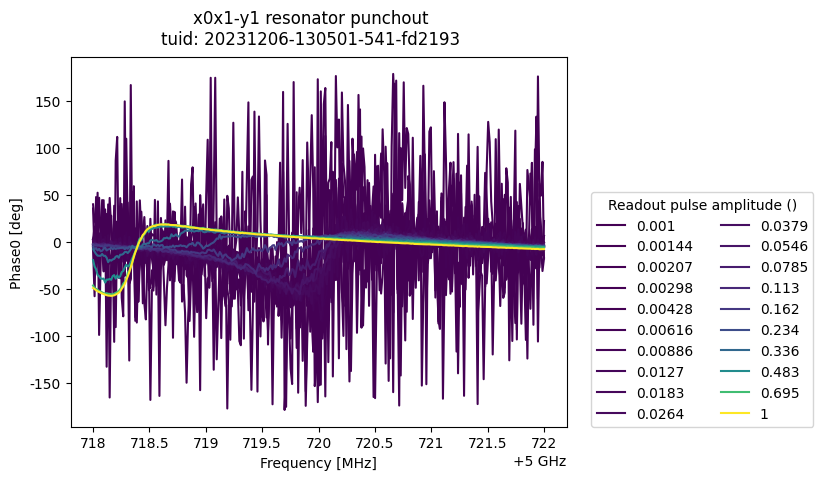

In [16]:
# Parameters 
meas_datadir = 'D:\HW\量子元件實驗室\Qblox\Qblox_datadir'
flux_val = 0.0
ro_out_att = 20
meas_repetitions = 80
meas_center_freq = 5.72e9  # Range ~4MHz
meas_range_freq = 2e6
meas_datapoint = 120
ro_power_start = -3       # With base = 10
ro_power_stop = 0         # With base = 10
ro_power_datapoints = 20

# ----------------------------separation line------------------------------------

dh.set_datadir(meas_datadir)

# Configure external flux control
flux_settable: callable = cluster.module2.out0_offset
flux_settable(flux_val)

# Activate NCO delay compensation
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

ro_pulse_amp = ManualParameter(name="ro_pulse_amp", unit="", label="Readout pulse amplitude")
ro_pulse_amp.batched = False
# Two axis need two ManualParameters

spec_sched_kwargs = dict(
    pulse_amp=ro_pulse_amp,
    pulse_duration=2e-6,
    frequencies=freq,
    acquisition_delay=196e-9,
    integration_time=2e-6,
    init_duration=10e-6,
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)
show_args(spec_sched_kwargs, title="spec_sched_kwargs")

# Set the value of all variables here
set_readout_attenuation(quantum_device, qubit, out_att=ro_out_att, in_att=0)

quantum_device.cfg_sched_repetitions(meas_repetitions)
frequency_setpoints = np.linspace(meas_center_freq - meas_range_freq, meas_center_freq + meas_range_freq, meas_datapoints)
ro_pulse_setpoints = np.logspace(ro_power_start, ro_power_stop, ro_power_datapoints)

meas_ctrl.settables([freq, ro_pulse_amp])
meas_ctrl.setpoints_grid((frequency_setpoints, ro_pulse_setpoints))

punchout_ds = meas_ctrl.run("resonator punchout")
punchout_ds

from quantify_core.analysis.base_analysis import Basic2DAnalysis

# Turn the plot of the amplitude into logarithm
b2a = Basic2DAnalysis(tuid=punchout_ds.attrs["tuid"], dataset=punchout_ds)
b2a.run().display_figs_mpl()

Flux dependent cavity
---
> Need to set output channel as a parameter

spec_sched_kwargs
pulse_amp         = 0.1
pulse_duration    = 2e-06
frequencies       = freq
acquisition_delay = 8e-08
integration_time  = 2e-06
init_duration     = 0.0002
port              = qubit:res
clock             = qubit.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out0_offset 
Batched settable(s):
	 freq 
Batch size limit: 100

100% completed | elapsed time:    100s | time left:      0s  last batch size:    100  
100% completed | elapsed time:    100s | time left:      0s  last batch size:    100  

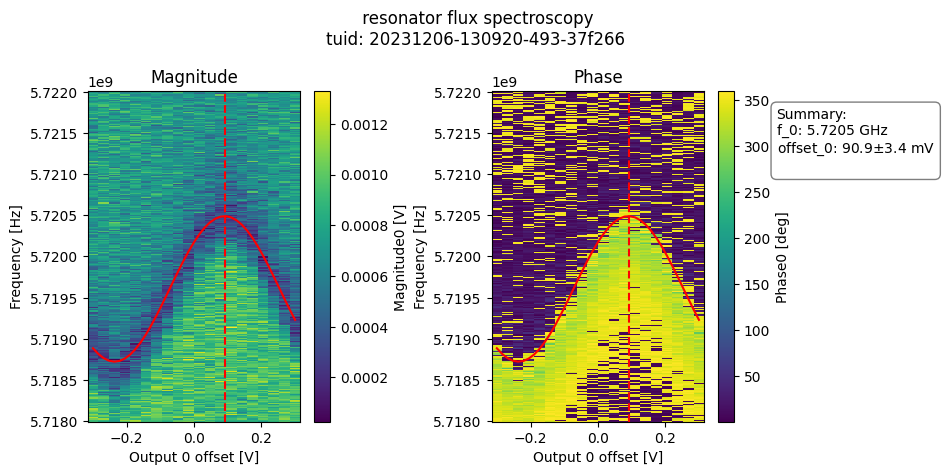

In [18]:
# Parameters 
meas_datadir = 'D:\HW\量子元件實驗室\Qblox\Qblox_datadir'
flux_val = 0.0
ro_out_att = 40
meas_repetitions = 50
meas_center_freq = 5.72e9  
meas_range_freq = 2e6      # Range ~4MHz
meas_datapoint = 300
flux_start = -0.3       
flux_stop = 0.3            # unit: volt
flux_datapoints = 20

# ----------------------------separation line------------------------------------

dh.set_datadir(meas_datadir)

# Activate NCO delay compensation
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True
freq.batch_size = 100

spec_sched_kwargs = dict(
    pulse_amp=0.1,
    pulse_duration=2e-6,
    frequencies=freq,
    acquisition_delay=80e-9,
    integration_time=2e-6,
    init_duration=200e-6,
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)
show_args(spec_sched_kwargs, title="spec_sched_kwargs")

set_readout_attenuation(quantum_device, qubit, out_att=ro_out_att, in_att=0)

quantum_device.cfg_sched_repetitions(meas_repetitions)
frequency_setpoints = np.linspace(meas_center_freq - meas_range_freq, meas_center_freq + meas_range_freq, meas_datapoints)
flux_setpoints = np.linspace(flux_start, flux_stop, flux_datapoints)

meas_ctrl.settables([freq, flux_settable])  # *** Is 'flux_settable' a function in meas_ctrl? Is there any other function that I can use?
meas_ctrl.setpoints_grid((frequency_setpoints, flux_setpoints))

rfs_ds = meas_ctrl.run("resonator flux spectroscopy")
rfs_ds

rfs_analysis = ResonatorFluxSpectroscopyAnalysis(tuid=rfs_ds.attrs["tuid"], dataset=rfs_ds)
rfs_analysis.run(fit_method="fast", sweetspot_index=0).display_figs_mpl()

Two-tone
----

> Under construction


qubit_spec_sched_kwargs
spec_pulse_amp         = 1
spec_pulse_duration    = 4.8e-05
spec_pulse_port        = qubit:mw
spec_pulse_clock       = qubit.01
spec_pulse_frequencies = freq
ro_pulse_amp           = 0.1
ro_pulse_duration      = 3e-06
ro_pulse_delay         = 1e-07
ro_pulse_port          = qubit:res
ro_pulse_clock         = qubit.ro
ro_pulse_frequency     = 5719800000.0
ro_acquisition_delay   = 4.8e-07
ro_integration_time    = 2e-06
init_duration          = 0.0001
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 400

100% completed | elapsed time:     61s | time left:      0s  last batch size:    400  
100% completed | elapsed time:     61s | time left:      0s  last batch size:    400  

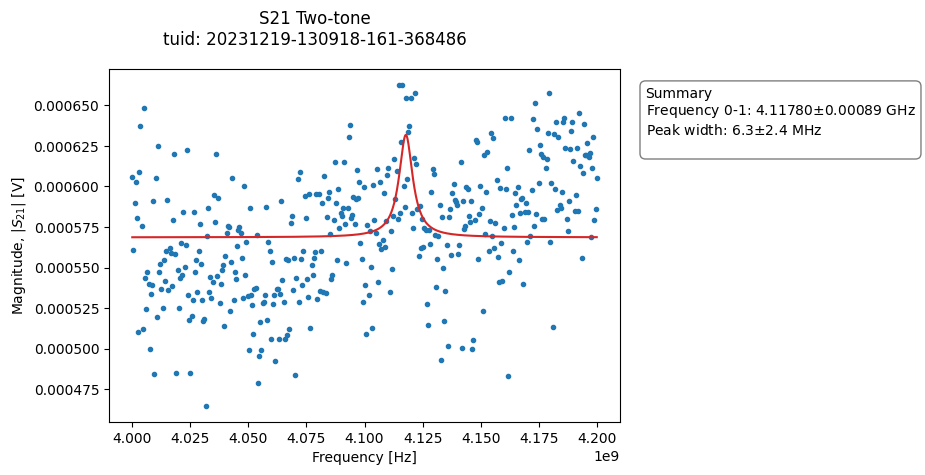

In [12]:
# Parameters 
meas_datadir = 'D:\HW\量子元件實驗室\Qblox\Qblox_datadir'
flux_val = 0.0
ro_out_att = 36
xy_out_att = 18
meas_repetitions = 1000
meas_freq = 5.7198e9
xy_center_freq = 4.10e9
xy_range_freq = 100e6
xy_datapoints = 400
xy_pulse_duration = 48e-6

# ----------------------------separation line------------------------------------

dh.set_datadir(meas_datadir)

# Configure external flux control
flux_settable: callable = cluster.module2.out0_offset
flux_settable(flux_val)

# Activate NCO delay compensation
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

qubit_spec_sched_kwargs = dict(
    spec_pulse_amp=1,
    spec_pulse_duration=xy_pulse_duration,
    spec_pulse_port=qubit.ports.microwave(),
    spec_pulse_clock=qubit.name + ".01",
    spec_pulse_frequencies=freq,
    ro_pulse_amp=0.1,
    ro_pulse_duration=3e-6,
    ro_pulse_delay=100e-9,
    ro_pulse_port=qubit.ports.readout(),
    ro_pulse_clock=qubit.name + ".ro",
    ro_pulse_frequency=meas_freq,
    ro_acquisition_delay=48e-8,
    ro_integration_time=2e-6,
    init_duration=100e-6,
    
)

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=two_tone_spec_sched_nco,
    schedule_kwargs=qubit_spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)
show_args(qubit_spec_sched_kwargs, title="qubit_spec_sched_kwargs")

set_readout_attenuation(quantum_device, qubit, out_att=ro_out_att, in_att=0)
set_drive_attenuation(quantum_device, qubit, out_att=xy_out_att)

quantum_device.cfg_sched_repetitions(meas_repetitions)
frequency_setpoints = np.linspace(xy_center_freq - xy_range_freq, xy_center_freq + xy_range_freq, xy_datapoints)
meas_ctrl.settables(freq)
meas_ctrl.setpoints(frequency_setpoints)

qs_ds = meas_ctrl.run("Two-tone")
qs_ds

qs_analysis = QubitSpectroscopyAnalysis(tuid=qs_ds.attrs["tuid"], dataset=qs_ds)
qs_analysis.run().display_figs_mpl()

## Stop Sequencer& Cluster
